<h1>Microsoft Malware detection</h1>

<h1>Exploratory Data Analysis</h1>

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle
from google.colab import files
from datetime import datetime
api_token = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c 'malware-classification'

100% 17.5G/17.5G [06:00<00:00, 63.3MB/s]
100% 17.5G/17.5G [06:00<00:00, 52.2MB/s]
100% 265k/265k [00:00<00:00, 437kB/s]

  0% 0.00/185k [00:00<?, ?B/s]
100% 185k/185k [00:00<00:00, 56.2MB/s]
100% 4.06M/4.06M [00:00<00:00, 42.6MB/s]

100% 17.8G/17.8G [05:13<00:00, 49.7MB/s]
100% 17.8G/17.8G [05:13<00:00, 60.9MB/s]


In [ ]:
# Keep only train.7z, trainLables files remove other files as shown below
!rm test.7z
!rm sampleSubmission.csv.zip
!rm dataSample.7z

In [ ]:
# 
data=!7z l train.7z
print(len(data))
print(type(data))

21759
<class 'IPython.utils.text.SList'>


In [ ]:
byte_file_list=[]
asm_file_list=[]
others=[]
for i in data:
  if (i.endswith("bytes")):
    byte_file_list.append(i)
  elif (i.endswith("asm")):
    asm_file_list.append(i)

In [ ]:
print('Number of Byte files',len(byte_file_list))

Number of Byte files 10868


In [ ]:
print('Number of ASM files',len(asm_file_list))

Number of ASM files 10868


In [ ]:
# Doing the same operation for all the files
byte_file_name=[]
for i in range(0,len(byte_file_list)):
  byte_file_name.append(byte_file_list[i].split()[-1].replace('train/', ''))

In [ ]:
byte_file_name[:3]

['01azqd4InC7m9JpocGv5.bytes',
 '01IsoiSMh5gxyDYTl4CB.bytes',
 '01jsnpXSAlgw6aPeDxrU.bytes']

In [ ]:
# Finding only the file names of ASM files and storing the file names in an array
asm_file_name=[]
for i in range(0,len(asm_file_list)):
  asm_file_name.append(asm_file_list[i].split()[-1].replace('train/', ''))

In [ ]:
asm_file_name[:3]

['01azqd4InC7m9JpocGv5.asm',
 '01IsoiSMh5gxyDYTl4CB.asm',
 '01jsnpXSAlgw6aPeDxrU.asm']

In [ ]:
import os
# Getting the current working directory
os.getcwd()

'/content'

In [ ]:
os.listdir()

['.config',
 'trainLabels.csv',
 'train.7z',
 'kaggle.json',
 'drive',
 'sample_data']

In [ ]:
byte_file_name[0]

'01azqd4InC7m9JpocGv5.bytes'

In [ ]:
# Downloading only a single byte file from train.7z
%%time
file_name=byte_file_name[0]
!7z e train.7z -o/content *$file_name -r


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 18810691091 bytes (18 GiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 18810691091
Headers Size = 339764
Method = LZMA:24
Solid = +
Blocks = 94

  0%      3% . train/kQEbWRHa04gOYDqM1NJ6.asm                                       8% 1 . train/KqEgONxfHdP5lLaBIGQk.asm                                        12% 1 . train/KqEgONxfHdP5lLaBIGQk.asm                                        17% 1 . train/KqEgONxfHdP5lLaBIGQk.asm

In [ ]:
# Deleting the file
os.remove(file_name)

In [ ]:
!mkdir byteFiles

In [ ]:
#To download all the byte files from train.7z and below code will take almost 15mins.
start=datetime.now()

!7z e train.7z -o/content/byteFiles *.bytes -r

end=datetime.now()
difference=end-start
print('Time taken to extract all the byte files',difference)


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 18810691091 bytes (18 GiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 18810691091
Headers Size = 339764
Method = LZMA:24
Solid = +
Blocks = 94

  0%      0% . train/kQEbWRHa04gOYDqM1NJ6.asm                                       0% 1 . train/KqEgONxfHdP5lLaBIGQk.asm                                         0% 2 . train/kqiOdVbRQlB2s907GLMv.asm                                         0% 5 . train/kQsiVxDbAXt23wRWal57.asm

In [ ]:
for file in byte_file_name[4200:]:
    os.remove('byteFiles/'+file)

In [ ]:
print('Number of byte files extracted is',len(os.listdir('byteFiles/')))

Number of byte files extracted is 4200


In [ ]:
#https://www.thepythoncode.com/article/get-directory-size-in-bytes-using-python

def get_directory_size(directory):
    """Returns the `directory` size in bytes."""
    total = 0
    try:
        # print("[+] Getting the size of", directory)
        for entry in os.scandir(directory):
            if entry.is_file():
                # if it's a file, use stat() function
                total += entry.stat().st_size
            elif entry.is_dir():
                # if it's a directory, recursively call this function
                total += get_directory_size(entry.path)
    except NotADirectoryError:
        # if `directory` isn't a directory, get the file size then
        return os.path.getsize(directory)
    except PermissionError:
        # if for whatever reason we can't open the folder, return 0
        return 0
    return total

In [ ]:
def get_size_format(b, factor=1024, suffix="B"):
    """
    Scale bytes to its proper byte format
    e.g:
        1253656 => '1.20MB'
        1253656678 => '1.17GB'
    """
    for unit in ["", "K", "M", "G", "T", "P", "E", "Z"]:
        if b < factor:
            return f"{b:.2f}{unit}{suffix}"
        b /= factor
    return f"{b:.2f}Y{suffix}"

In [ ]:
get_size_format(get_directory_size("byteFiles/"))

'18.50GB'

<h2>Distribution of malware classes in whole data set </h2>

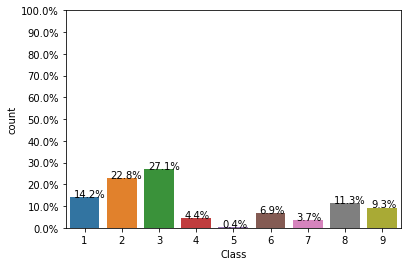

In [ ]:
Y=pd.read_csv("/content/drive/My Drive/Colab Notebooks/MicrosoftMalware/trainLabels.csv")
total = len(Y)*1.
ax=sns.countplot(x="Class", data=Y)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

<h2>Feature extraction </h2>

<h3>File size  of byte files as a feature </h3>

In [ ]:
#file sizes of byte files

#files=os.listdir('byteFiles')
filenames=Y['Id'].tolist()
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in byte_file_name[0:4200]:
    # print(os.stat('byteFiles/0A32eTdBKayjCWhZqDOQ.txt'))
    # os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
    # st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
    # read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm
    statinfo=os.stat('byteFiles/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
data_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes})
print (data_size_byte.head())

                     ID      size  Class
0  01azqd4InC7m9JpocGv5  5.012695      9
1  01IsoiSMh5gxyDYTl4CB  6.556152      2
2  01jsnpXSAlgw6aPeDxrU  4.602051      9
3  01kcPWA9K2BOxQeS5Rju  0.679688      1
4  01SuzwMJEIXsK7A8dQbl  0.438965      8


In [ ]:
data_size_byte.to_csv('/content/drive/My Drive/Colab Notebooks/MicrosoftMalware/datasizebyte.csv', index=False)

<h3>box plots of file size (.byte files) feature </h3>

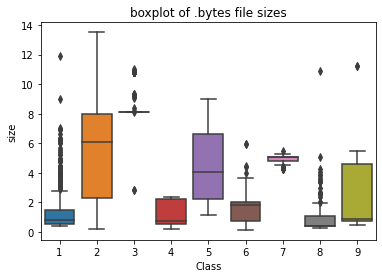

In [ ]:
#boxplot of byte files
ax = sns.boxplot(x="Class", y="size", data=data_size_byte)
plt.title("boxplot of .bytes file sizes")
plt.show()

<h3>feature extraction from byte files </h3>

In [ ]:
#removal of addres from byte files
# contents of .byte files
# ----------------
#00401000 56 8D 44 24 08 50 8B F1 E8 1C 1B 00 00 C7 06 08 
#-------------------
#we remove the starting address 00401000

files = os.listdir('byteFiles')
filenames=[]
array=[]
for file in files:
    if(file.endswith("bytes")):
        file=file.split('.')[0]
        text_file = open('byteFiles/'+file+".txt", 'w+')
        with open('byteFiles/'+file+".bytes","r") as fp:
            lines=""
            for line in fp:
                a=line.rstrip().split(" ")[1:]
                b=' '.join(a)
                b=b+"\n"
                text_file.write(b)
            fp.close()
            os.remove('byteFiles/'+file+".bytes")
        text_file.close()


In [ ]:

files = os.listdir('byteFiles')
filenames2=[]
feature_matrix = np.zeros((len(files),257),dtype=int)
k=0


#program to convert into bag of words of bytefiles
#this is custom-built bag of words this is unigram bag of words
byte_feature_file=open('result.csv','w+')
byte_feature_file.write("ID,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,2b,2c,2d,2e,2f,30,31,32,33,34,35,36,37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,66,67,68,69,6a,6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,87,88,89,8a,8b,8c,8d,8e,8f,90,91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,ba,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,db,dc,dd,de,df,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff,??")
byte_feature_file.write("\n")
for file in files:
    filenames2.append(file)
    byte_feature_file.write(file+",")
    if(file.endswith("txt")):
        with open('byteFiles/'+file,"r") as byte_flie:
            for lines in byte_flie:
                line=lines.rstrip().split(" ")
                for hex_code in line:
                    if hex_code=='??':
                        feature_matrix[k][256]+=1
                    else:
                        feature_matrix[k][int(hex_code,16)]+=1
        byte_flie.close()
    for i, row in enumerate(feature_matrix[k]):
        if i!=len(feature_matrix[k])-1:
            byte_feature_file.write(str(row)+",")
        else:
            byte_feature_file.write(str(row))
    byte_feature_file.write("\n")
    
    k += 1

byte_feature_file.close()

In [ ]:
byte_features=pd.read_csv("/content/drive/My Drive/Colab Notebooks/MicrosoftMalware/result.csv")
byte_features['ID']  = byte_features['ID'].str.split('.').str[0]
byte_features.head(2)

ID       0     1     2  ...    fd     fe     ff    ??
0  01azqd4InC7m9JpocGv5  601905  3905  2816  ...  3099   2759   5753  1824
1  01IsoiSMh5gxyDYTl4CB   39755  8337  7249  ...   518  17001  54902  8588

[2 rows x 258 columns]

In [ ]:
# Get indexes 
indexNames=[]
for file in byte_file_name[4200:]:
    file=file.split('.')[0]
    indexNames=byte_features[byte_features['ID'] ==file].index
    byte_features.drop(indexNames,inplace=True)

In [ ]:
byte_features.shape

(4200, 258)

In [ ]:
data_size_byte=pd.read_csv('/content/drive/My Drive/Colab Notebooks/MicrosoftMalware/datasizebyte.csv')

In [ ]:
data_size_byte.head(2)

ID      size  Class
0  01azqd4InC7m9JpocGv5  5.012695      9
1  01IsoiSMh5gxyDYTl4CB  6.556152      2

In [ ]:
data_size_byte.shape

(4200, 3)

In [ ]:
byte_features_with_size = byte_features.merge(data_size_byte, on='ID')
byte_features_with_size.to_csv('/content/drive/My Drive/Colab Notebooks/MicrosoftMalware/unigram_byte_features.csv', index=False)
byte_features_with_size.head(2)

ID       0     1     2  ...     ff    ??      size  Class
0  01azqd4InC7m9JpocGv5  601905  3905  2816  ...   5753  1824  5.012695      9
1  01IsoiSMh5gxyDYTl4CB   39755  8337  7249  ...  54902  8588  6.556152      2

[2 rows x 260 columns]

In [ ]:
# https://stackoverflow.com/a/29651514
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1
result_unigrams= normalize(byte_features_with_size)

In [ ]:
result_unigrams.head(2)

ID         0         1  ...        ??      size  Class
0  01azqd4InC7m9JpocGv5  0.527809  0.008309  ...  0.000752  0.364407      9
1  01IsoiSMh5gxyDYTl4CB  0.034861  0.017739  ...  0.003540  0.479873      2

[2 rows x 260 columns]

In [ ]:
data_y = result_unigrams['Class']
result_unigrams.head()

ID         0         1  ...        ??      size  Class
0  01azqd4InC7m9JpocGv5  0.527809  0.008309  ...  0.000752  0.364407      9
1  01IsoiSMh5gxyDYTl4CB  0.034861  0.017739  ...  0.003540  0.479873      2
2  01jsnpXSAlgw6aPeDxrU  0.081995  0.020303  ...  0.000193  0.333686      9
3  01kcPWA9K2BOxQeS5Rju  0.018495  0.002581  ...  0.005746  0.040254      1
4  01SuzwMJEIXsK7A8dQbl  0.017331  0.001511  ...  0.003713  0.022246      8

[5 rows x 260 columns]

<h3>Multivariate Analysis </h3>

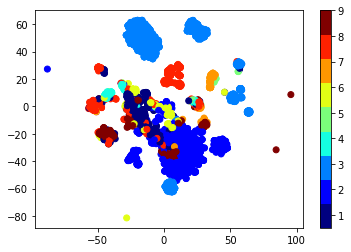

In [ ]:
#multivariate analysis on byte files
#this is with perplexity 50
xtsne=TSNE(perplexity=50)
results=xtsne.fit_transform(result_unigrams.drop(['ID','Class'], axis=1))
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

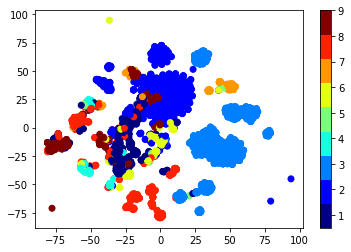

In [ ]:
#this is with perplexity 30
xtsne=TSNE(perplexity=30)
results=xtsne.fit_transform(result_unigrams.drop(['ID','Class'], axis=1))
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

<h1>Train Test split</h1>

In [ ]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(result_unigrams.drop(['ID','Class'], axis=1), data_y,stratify=data_y,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

In [ ]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 2688
Number of data points in test data: 840
Number of data points in cross validation data: 672


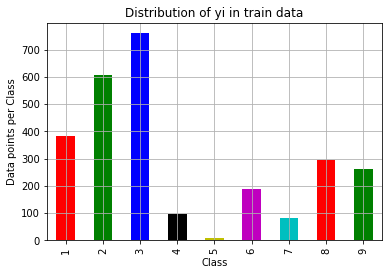

Number of data points in class 3 : 760 ( 28.274 %)
Number of data points in class 2 : 606 ( 22.545 %)
Number of data points in class 1 : 385 ( 14.323 %)
Number of data points in class 8 : 294 ( 10.938 %)
Number of data points in class 9 : 263 ( 9.784 %)
Number of data points in class 6 : 190 ( 7.068 %)
Number of data points in class 4 : 97 ( 3.609 %)
Number of data points in class 7 : 83 ( 3.088 %)
Number of data points in class 5 : 10 ( 0.372 %)
--------------------------------------------------------------------------------


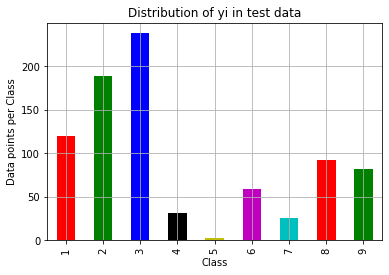

Number of data points in class 3 : 238 ( 28.333 %)
Number of data points in class 2 : 189 ( 22.5 %)
Number of data points in class 1 : 120 ( 14.286 %)
Number of data points in class 8 : 92 ( 10.952 %)
Number of data points in class 9 : 82 ( 9.762 %)
Number of data points in class 6 : 59 ( 7.024 %)
Number of data points in class 4 : 31 ( 3.69 %)
Number of data points in class 7 : 26 ( 3.095 %)
Number of data points in class 5 : 3 ( 0.357 %)
--------------------------------------------------------------------------------


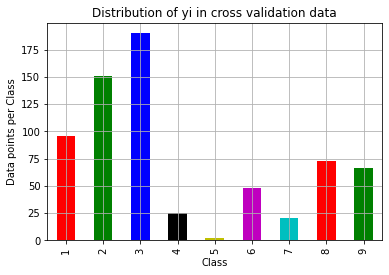

Number of data points in class 3 : 190 ( 28.274 %)
Number of data points in class 2 : 151 ( 22.47 %)
Number of data points in class 1 : 96 ( 14.286 %)
Number of data points in class 8 : 73 ( 10.863 %)
Number of data points in class 9 : 66 ( 9.821 %)
Number of data points in class 6 : 48 ( 7.143 %)
Number of data points in class 4 : 25 ( 3.72 %)
Number of data points in class 7 : 21 ( 3.125 %)
Number of data points in class 5 : 2 ( 0.298 %)


In [ ]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = y_train.value_counts().sort_index()
test_class_distribution = y_test.value_counts().sort_index()
cv_class_distribution = y_cv.value_counts().sort_index()

#my_colors = 'rgbkymc'
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
train_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/y_train.shape[0]*100), 3), '%)')

    
print('-'*80)
#my_colors = 'rgbkymc'
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
test_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/y_test.shape[0]*100), 3), '%)')

print('-'*80)
#my_colors = 'rgbkymc'
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
cv_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/y_cv.shape[0]*100), 3), '%)')


In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

<h1>Machine Learning Models</h1>

<h2>Machine Leaning Models on bytes files</h2>

<h3>Random Forest Classifier </h3>

log_loss for c =  10 is 0.1581146169229295
log_loss for c =  50 is 0.1361182149991945
log_loss for c =  100 is 0.13473435102865686
log_loss for c =  500 is 0.13207051674499212
log_loss for c =  1000 is 0.1314833067208998
log_loss for c =  2000 is 0.13166404052759942
log_loss for c =  3000 is 0.13163521527727365


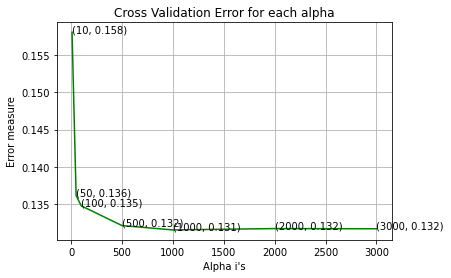

For values of best alpha =  1000 The train log loss is: 0.05172860379810071
For values of best alpha =  1000 The cross validation log loss is: 0.1314833067208998
For values of best alpha =  1000 The test log loss is: 0.12470485683648486
Number of misclassified points  2.619047619047619
-------------------------------------------------- Confusion matrix --------------------------------------------------


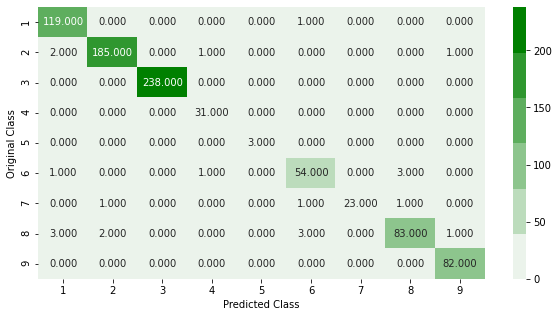

-------------------------------------------------- Precision matrix --------------------------------------------------


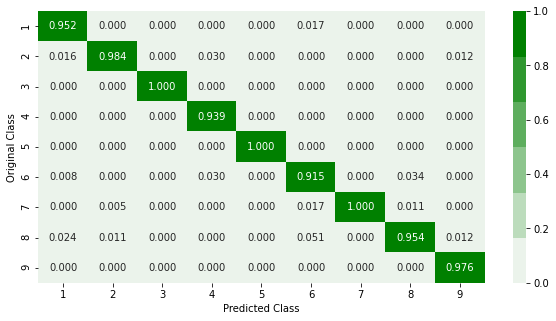

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


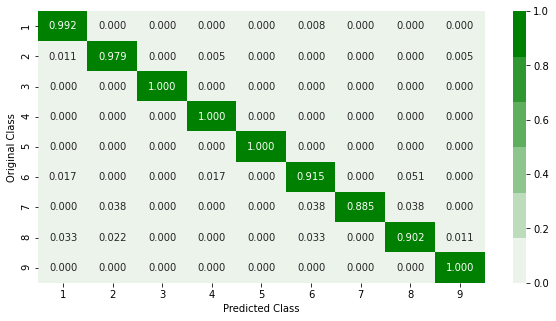

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

<h3>XgBoost Classification</h3>

log_loss for c =  10 is 0.2643614017218104
log_loss for c =  50 is 0.16551918621733153
log_loss for c =  100 is 0.1279590584343865
log_loss for c =  500 is 0.12315508514275281
log_loss for c =  1000 is 0.12378642313827701
log_loss for c =  2000 is 0.12374543254492758


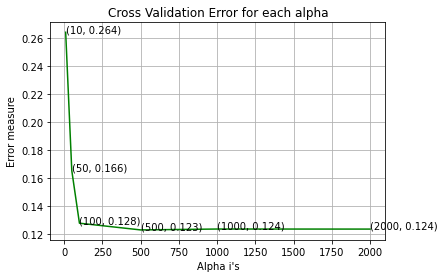

For values of best alpha =  500 The train log loss is: 0.0442552225726201
For values of best alpha =  500 The cross validation log loss is: 0.12315508514275281
For values of best alpha =  500 The test log loss is: 0.1110404092953692
Number of misclassified points  2.142857142857143
-------------------------------------------------- Confusion matrix --------------------------------------------------


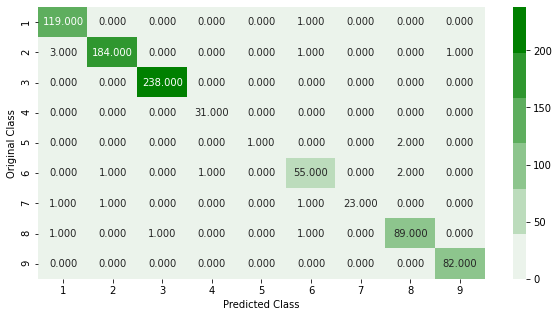

-------------------------------------------------- Precision matrix --------------------------------------------------


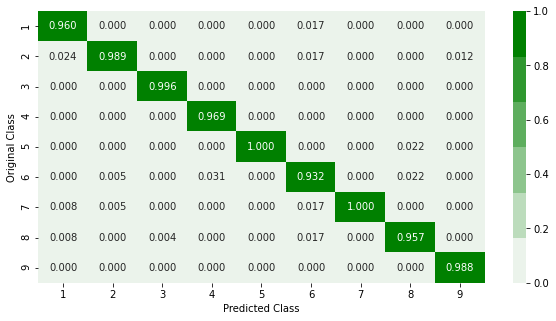

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


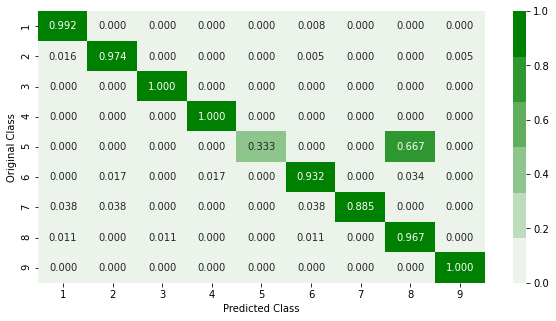

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

alpha=[10,50,100,500,1000,2000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

<h3> XgBoost Classification with best hyper parameters using RandomSearch </h3>

In [ ]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl1.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 16.4min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_it

In [ ]:
print (random_cfl1.best_params_)

{'subsample': 0.5, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.3}


In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

x_cfl=XGBClassifier(subsample=0.5,n_estimators=1000, learning_rate=0.1, colsample_bytree=0.3, max_depth=10)
x_cfl.fit(X_train,y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train,y_train)

predict_y = c_cfl.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))
predict_y = c_cfl.predict_proba(X_cv)
print ('cv loss',log_loss(y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test)
print ('test loss',log_loss(y_test, predict_y))

train loss 0.043766315258268185
cv loss 0.1135686844058138
test loss 0.10430377949228438


<h2>Modeling with .asm files </h2>

<h3>Feature extraction from asm files </h3>

In [ ]:
#intially create five folders
#first 
#second
#thrid
#fourth
#fifth
#this code tells us about random split of files into five folders
folder_1 ='first'
folder_2 ='second'
folder_3 ='third'
folder_4 ='fourth'
folder_5 ='fifth'
folder_6 = 'output'
for i in [folder_1,folder_2,folder_3,folder_4,folder_5,folder_6]:
    if not os.path.isdir(i):
        os.makedirs(i)

source='train/'
files = os.listdir('train')
ID=df['Id'].tolist()
data=range(0,10868)
r.shuffle(data)
count=0
for i in range(0,10868):
    if i % 5==0:
        shutil.move(source+files[data[i]],'first')
    elif i%5==1:
        shutil.move(source+files[data[i]],'second')
    elif i%5 ==2:
        shutil.move(source+files[data[i]],'thrid')
    elif i%5 ==3:
        shutil.move(source+files[data[i]],'fourth')
    elif i%5==4:
        shutil.move(source+files[data[i]],'fifth')

In [ ]:

#http://flint.cs.yale.edu/cs421/papers/x86-asm/asm.html

def firstprocess():
    #The prefixes tells about the segments that are present in the asm files
    #There are 450 segments(approx) present in all asm files.
    #this prefixes are best segments that gives us best values.
    #https://en.wikipedia.org/wiki/Data_segment
    
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    #this are opcodes that are used to get best results
    #https://en.wikipedia.org/wiki/X86_instruction_listings
    
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    #best keywords that are taken from different blogs
    keywords = ['.dll','std::',':dword']
    #Below taken registers are general purpose registers and special registers
    #All the registers which are taken are best 
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("output\asmsmallfile.txt","w+")
    files = os.listdir('first')
    for f in files:
        #filling the values with zeros into the arrays
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        opcodefile.write(f2+" ")
        # https://docs.python.org/3/library/codecs.html#codecs.ignore_errors
        # https://docs.python.org/3/library/codecs.html#codecs.Codec.encode
        with codecs.open('first/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                # https://www.tutorialspoint.com/python3/string_rstrip.htm
                line=lines.rstrip().split()
                l=line[0]
                #counting the prefixs in each and every line
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                #counting the opcodes in each and every line
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                #counting registers in the line
                for i in range(len(registers)):
                    for li in line:
                        # we will use registers only in 'text' and 'CODE' segments
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                #counting keywords in the line
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        #pushing the values into the file after reading whole file
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
    file1.close()


#same as above 
def secondprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("output\mediumasmfile.txt","w+")
    files = os.listdir('second')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        opcodefile.write(f2+" ")
        with codecs.open('second/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
    file1.close()

# same as smallprocess() functions
def thirdprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("output\largeasmfile.txt","w+")
    files = os.listdir('thrid')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        opcodefile.write(f2+" ")
        with codecs.open('thrid/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
    file1.close()


def fourthprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("output\hugeasmfile.txt","w+")
    files = os.listdir('fourth/')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        opcodefile.write(f2+" ")
        with codecs.open('fourth/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
    file1.close()


def fifthprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("output\trainasmfile.txt","w+")
    files = os.listdir('fifth/')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        opcodefile.write(f2+" ")
        with codecs.open('fifth/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
    file1.close()


def main():
    #the below code is used for multiprogramming
    #the number of process depends upon the number of cores present System
    #process is used to call multiprogramming
    manager=multiprocessing.Manager() 	
    p1=Process(target=firstprocess)
    p2=Process(target=secondprocess)
    p3=Process(target=thirdprocess)
    p4=Process(target=fourthprocess)
    p5=Process(target=fifthprocess)
    #p1.start() is used to start the thread execution
    p1.start()
    p2.start()
    p3.start()
    p4.start()
    p5.start()
    #After completion all the threads are joined
    p1.join()
    p2.join()
    p3.join()
    p4.join()
    p5.join()

if __name__=="__main__":
    main()

In [ ]:
# asmoutputfile.csv(output genarated from the above two cells) will contain all the extracted features from .asm files
# this file will be uploaded in the drive, you can directly use this
dfasm=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MicrosoftMalware/asmoutputfile.csv")
Y.columns = ['ID', 'Class']
result_asm = pd.merge(dfasm, Y,on='ID', how='left')
result_asm.head()

ID  HEADER:  .text:  .Pav:  ...  ebp  esp  eip  Class
0  01kcPWA9K2BOxQeS5Rju       19     744      0  ...   17   48   29      1
1  1E93CpP60RHFNiT5Qfvn       17     838      0  ...   14    0   20      1
2  3ekVow2ajZHbTnBcsDfX       17     427      0  ...   11    0    9      1
3  3X2nY7iQaPBIWDrAZqJe       17     227      0  ...    8    0    6      1
4  46OZzdsSKDCFV8h7XWxf       17     402      0  ...   11    0   11      1

[5 rows x 53 columns]

In [ ]:
# Get indexes 
indexNames=[]
for file in asm_file_name[4200:]:
    file=file.split('.')[0]
    indexNames=result_asm[result_asm['ID'] ==file].index
    result_asm.drop(indexNames,inplace=True)

<h4>Files sizes of each .asm file </h4>

In [ ]:
filenames=Y['Id'].tolist()
class_y=Y['Class'].tolist()
class_bytes=[]
fnames=[]

In [ ]:
asm_size=pickle.load(open("/content/drive/MyDrive/Colab Notebooks/MicrosoftMalware/asmsize.p","rb"))

In [ ]:
for file in asm_file_name[0:4200]:
  # split the file name at '.' and take the first part of it i.e the file name
  file=file.split('.')[0]
  if any(file == filename for filename in filenames):
      i=filenames.index(file)
      class_bytes.append(class_y[i])
      fnames.append(file)

In [ ]:
asm_size_byte=pd.DataFrame({'ID':fnames,'size':asm_size,'Class':class_bytes})
print (asm_size_byte.head())

                     ID       size  Class
0  01azqd4InC7m9JpocGv5  56.229886      9
1  01IsoiSMh5gxyDYTl4CB  13.999378      2
2  01jsnpXSAlgw6aPeDxrU   8.507785      9
3  01kcPWA9K2BOxQeS5Rju   0.078190      1
4  01SuzwMJEIXsK7A8dQbl   0.996723      8


In [ ]:
asm_size_byte.to_csv('/content/drive/My Drive/Colab Notebooks/MicrosoftMalware/asmsize.csv', index=False)

In [ ]:
asm_size_byte=pd.read_csv('/content/drive/My Drive/Colab Notebooks/MicrosoftMalware/asmsize.csv')

<h4>Distribution of .asm file sizes</h4>

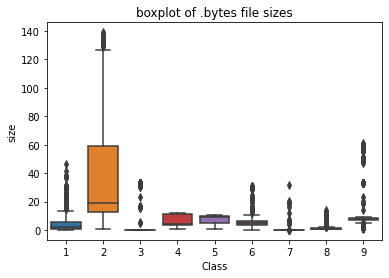

In [ ]:
#boxplot of asm files
ax = sns.boxplot(x="Class", y="size", data=asm_size_byte)
plt.title("boxplot of .bytes file sizes")
plt.show()

In [ ]:
# add the file size feature to previous extracted features
print(result_asm.shape)
print(asm_size_byte.shape)
result_asm = pd.merge(result_asm, asm_size_byte.drop(['Class'], axis=1),on='ID', how='left')
result_asm.head()

(4200, 53)
(4200, 3)


ID  HEADER:  .text:  .Pav:  ...  esp  eip  Class      size
0  01kcPWA9K2BOxQeS5Rju       19     744      0  ...   48   29      1  0.078190
1  1E93CpP60RHFNiT5Qfvn       17     838      0  ...    0   20      1  0.063400
2  3ekVow2ajZHbTnBcsDfX       17     427      0  ...    0    9      1  0.041695
3  3X2nY7iQaPBIWDrAZqJe       17     227      0  ...    0    6      1  0.018757
4  46OZzdsSKDCFV8h7XWxf       17     402      0  ...    0   11      1  0.037567

[5 rows x 54 columns]

In [ ]:
result_asm.to_csv('/content/drive/My Drive/Colab Notebooks/MicrosoftMalware/asm_features.csv', index=False)

In [ ]:
# https://stackoverflow.com/a/29651514
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1
result_asm = normalize(result_asm)
result_asm.head()

ID   HEADER:    .text:  ...       eip  Class          size
0  01kcPWA9K2BOxQeS5Rju  0.215909  0.001092  ...  0.003173      1  4.278698e-04
1  1E93CpP60RHFNiT5Qfvn  0.193182  0.001230  ...  0.002188      1  3.215958e-04
2  3ekVow2ajZHbTnBcsDfX  0.193182  0.000627  ...  0.000985      1  1.656338e-04
3  3X2nY7iQaPBIWDrAZqJe  0.193182  0.000333  ...  0.000657      1  8.119654e-07
4  46OZzdsSKDCFV8h7XWxf  0.193182  0.000590  ...  0.001204      1  1.359719e-04

[5 rows x 54 columns]

In [ ]:
data_y=result_asm['Class']

<h3>Univariate analysis on  asm file features</h3>

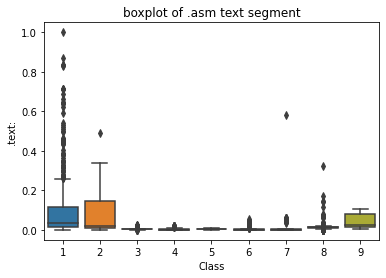

In [ ]:
ax = sns.boxplot(x="Class", y=".text:", data=result_asm)
plt.title("boxplot of .asm text segment")
plt.show()

<pre>
The plot is between Text and class 
Class 1,2 and 9 can be easly separated
</pre>

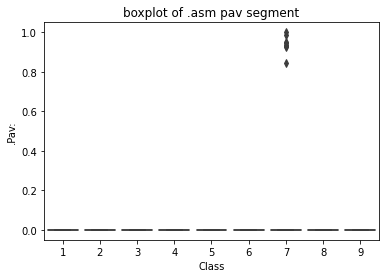

In [ ]:
ax = sns.boxplot(x="Class", y=".Pav:", data=result_asm)
plt.title("boxplot of .asm pav segment")
plt.show()

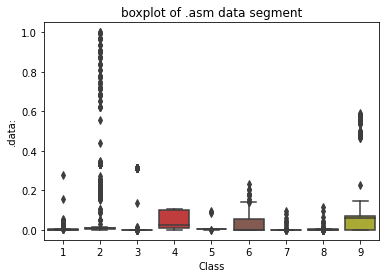

In [ ]:
ax = sns.boxplot(x="Class", y=".data:", data=result_asm)
plt.title("boxplot of .asm data segment")
plt.show()

<pre>
The plot is between data segment and class label 
class 6 and class 9 can be easily separated from given points
</pre>

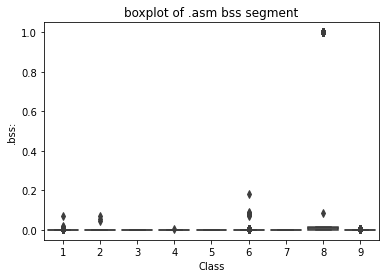

In [ ]:
ax = sns.boxplot(x="Class", y=".bss:", data=result_asm)
plt.title("boxplot of .asm bss segment")
plt.show()

<pre>
plot between bss segment and class label
very less number of files are having bss segment
</pre>

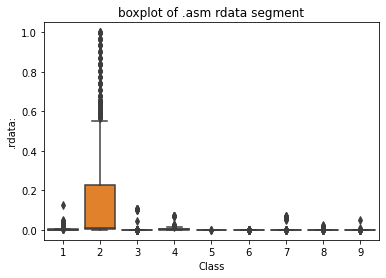

In [ ]:
ax = sns.boxplot(x="Class", y=".rdata:", data=result_asm)
plt.title("boxplot of .asm rdata segment")
plt.show()

<pre>
Plot between rdata segment and Class segment
Class 2 can be easily separated 75 pecentile files are having 1M rdata lines
</pre>

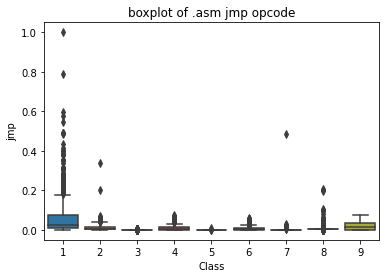

In [ ]:
ax = sns.boxplot(x="Class", y="jmp", data=result_asm)
plt.title("boxplot of .asm jmp opcode")
plt.show()

<pre>
plot between jmp and Class label
Class 1 is having frequency of 2000 approx in 75 perentile of files
</pre>

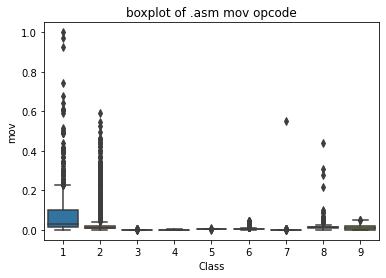

In [ ]:
ax = sns.boxplot(x="Class", y="mov", data=result_asm)
plt.title("boxplot of .asm mov opcode")
plt.show()

<pre>
plot between Class label and mov opcode
Class 1 is having frequency of 2000 approx in 75 perentile of files
</pre>

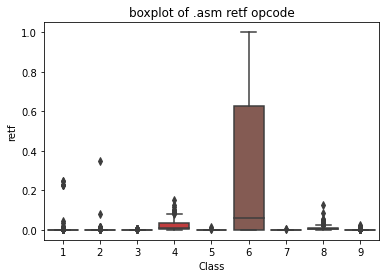

In [ ]:
ax = sns.boxplot(x="Class", y="retf", data=result_asm)
plt.title("boxplot of .asm retf opcode")
plt.show()

<pre>
plot between Class label and retf
Class 6 can be easily separated with opcode retf
The frequency of retf is approx of 250.
</pre>

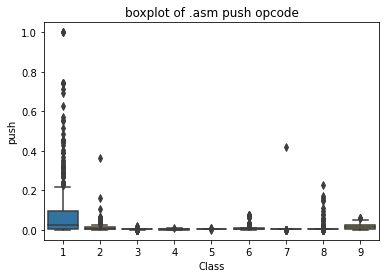

In [ ]:
ax = sns.boxplot(x="Class", y="push", data=result_asm)
plt.title("boxplot of .asm push opcode")
plt.show()

<pre>
plot between push opcode and Class label
Class 1 is having 75 precentile files with push opcodes of frequency 1000
</pre>

<h3>Multivariate Analysis on .asm file features </h3>

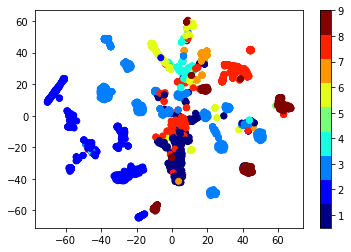

In [ ]:
# check out the course content for more explantion on tsne algorithm
# https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/t-distributed-stochastic-neighbourhood-embeddingt-sne-part-1/

#multivariate analysis on byte files
#this is with perplexity 50
xtsne=TSNE(perplexity=50)
results=xtsne.fit_transform(result_asm.drop(['ID','Class'], axis=1).fillna(0))
vis_x = results[:, 0]
vis_y = results[:, 1   ]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

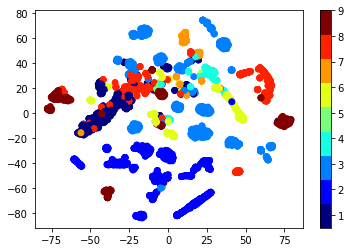

In [ ]:
# by univariate analysis on the .asm file features we are getting very negligible information from 
# 'rtn', '.BSS:' '.CODE' features, so heare we are trying multivariate analysis after removing those features
# the plot looks very messy

xtsne=TSNE(perplexity=30)
results=xtsne.fit_transform(result_asm.drop(['ID','Class', 'rtn', '.BSS:', '.CODE','size'], axis=1))
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

<h3>Conclusion on EDA</h3>

<p>
<li>We have taken only 52 features from asm files (after reading through many blogs and research papers) </li>
<li>The univariate analysis was done only on few important features.</li>
<li>Take-aways
<ul>
<li>1. Class 3 can be easily separated because of the frequency of segments,opcodes and keywords being less </li>
<li>2. Each feature has its unique importance in separating the Class labels.</li>
</ul>
</li>
</p>

<h2> 4.3 Train and test split</h2>

In [ ]:
asm_y = result_asm['Class']
asm_x = result_asm.drop(['ID','Class','.BSS:','rtn','.CODE'], axis=1)

In [ ]:
X_train_asm, X_test_asm, y_train_asm, y_test_asm = train_test_split(asm_x,asm_y ,stratify=asm_y,test_size=0.20)
X_train_asm, X_cv_asm, y_train_asm, y_cv_asm = train_test_split(X_train_asm, y_train_asm,stratify=y_train_asm,test_size=0.20)

In [ ]:
print( X_cv_asm.isnull().all())

HEADER:    False
.text:     False
.Pav:      False
.idata:    False
.data:     False
.bss:      False
.rdata:    False
.edata:    False
.rsrc:     False
.tls:      False
.reloc:    False
jmp        False
mov        False
retf       False
push       False
pop        False
xor        False
retn       False
nop        False
sub        False
inc        False
dec        False
add        False
imul       False
xchg       False
or         False
shr        False
cmp        False
call       False
shl        False
ror        False
rol        False
jnb        False
jz         False
lea        False
movzx      False
.dll       False
std::      False
:dword     False
edx        False
esi        False
eax        False
ebx        False
ecx        False
edi        False
ebp        False
esp        False
eip        False
size       False
dtype: bool


<h2>Machine Learning models on features of .asm files</h2>

<h3>Random Forest Classifier</h3>

log_loss for c =  10 is 0.06515049922494058
log_loss for c =  50 is 0.05624205220087841
log_loss for c =  100 is 0.054653070730925866
log_loss for c =  500 is 0.05508182067936471
log_loss for c =  1000 is 0.05463731669343906
log_loss for c =  2000 is 0.05434114700582415
log_loss for c =  3000 is 0.054480827020220716


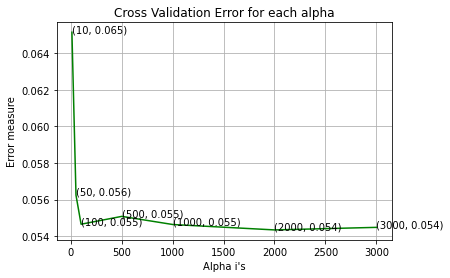

log loss for train data 0.02911851812914547
log loss for cv data 0.05434114700582415
log loss for test data 0.08250987226314102
Number of misclassified points  1.3095238095238095
-------------------------------------------------- Confusion matrix --------------------------------------------------


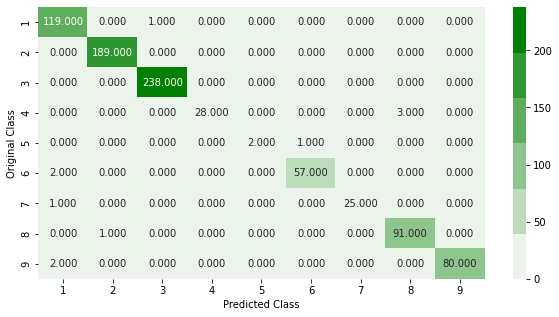

-------------------------------------------------- Precision matrix --------------------------------------------------


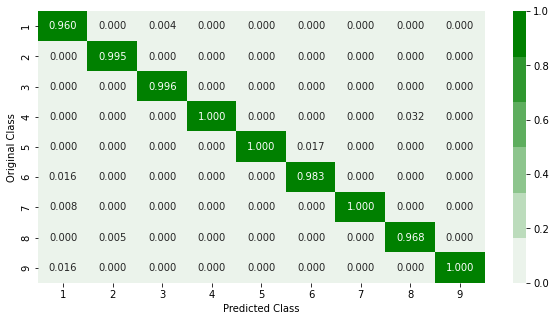

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


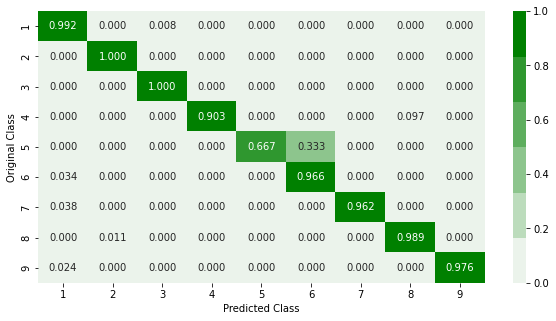

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)
predict_y = sig_clf.predict_proba(X_train_asm)
print ('log loss for train data',(log_loss(y_train_asm, predict_y, labels=sig_clf.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_cv_asm)
print ('log loss for cv data',(log_loss(y_cv_asm, predict_y, labels=sig_clf.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_test_asm)
print ('log loss for test data',(log_loss(y_test_asm, predict_y, labels=sig_clf.classes_, eps=1e-15)))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

<h3>XgBoost Classifier</h3>

log_loss for c =  10 is 0.10204416175917329
log_loss for c =  50 is 0.052217026898118475
log_loss for c =  100 is 0.04953210349860467
log_loss for c =  500 is 0.04963975720735575
log_loss for c =  1000 is 0.050352564444907266
log_loss for c =  2000 is 0.050923629791236824
log_loss for c =  3000 is 0.050786620718576196


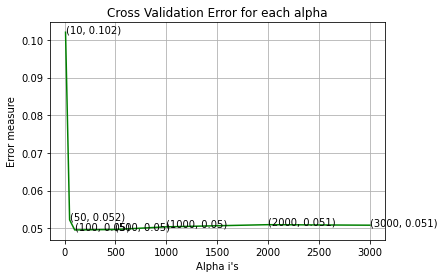

For values of best alpha =  100 The train log loss is: 0.027690434937473724
For values of best alpha =  100 The cross validation log loss is: 0.04953210349860467
For values of best alpha =  100 The test log loss is: 0.08837731358070451
Number of misclassified points  1.5476190476190477
-------------------------------------------------- Confusion matrix --------------------------------------------------


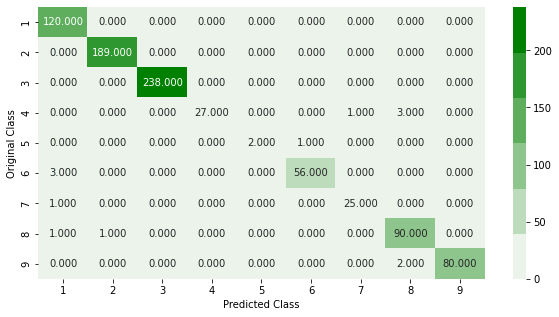

-------------------------------------------------- Precision matrix --------------------------------------------------


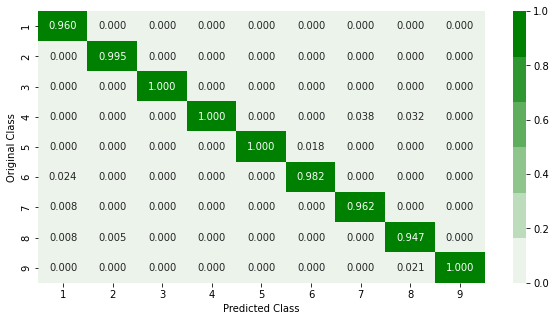

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


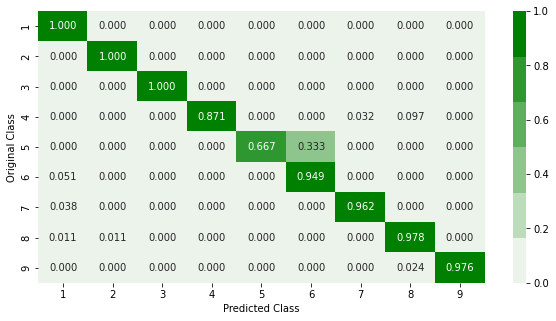

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)
    
predict_y = sig_clf.predict_proba(X_train_asm)

print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_asm, predict_y))
predict_y = sig_clf.predict_proba(X_cv_asm)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv_asm, predict_y))
predict_y = sig_clf.predict_proba(X_test_asm)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_asm, predict_y))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

<h3>Xgboost Classifier with best hyperparameters</h3>

In [ ]:
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(X_train_asm,y_train_asm)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.1min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_it

In [ ]:
print (random_cfl.best_params_)

{'subsample': 0.5, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 1}


In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

x_cfl=XGBClassifier(n_estimators=1000,subsample=0.5,learning_rate=0.2,colsample_bytree=1,max_depth=5)
x_cfl.fit(X_train_asm,y_train_asm)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train_asm,y_train_asm)

predict_y = c_cfl.predict_proba(X_train_asm)
print ('train loss',log_loss(y_train_asm, predict_y))
predict_y = c_cfl.predict_proba(X_cv_asm)
print ('cv loss',log_loss(y_cv_asm, predict_y))
predict_y = c_cfl.predict_proba(X_test_asm)
print ('test loss',log_loss(y_test_asm, predict_y))

train loss 0.02645576410921654
cv loss 0.04560387574546435
test loss 0.0815058774633491


<h2>Machine Learning models on features of both .asm and .bytes files</h2>

<h3>Merging both asm and byte file features</h3>

In [ ]:
result_unigrams.head()

ID         0         1  ...        ??      size  Class
0  01azqd4InC7m9JpocGv5  0.527809  0.008309  ...  0.000752  0.364407      9
1  01IsoiSMh5gxyDYTl4CB  0.034861  0.017739  ...  0.003540  0.479873      2
2  01jsnpXSAlgw6aPeDxrU  0.081995  0.020303  ...  0.000193  0.333686      9
3  01kcPWA9K2BOxQeS5Rju  0.018495  0.002581  ...  0.005746  0.040254      1
4  01SuzwMJEIXsK7A8dQbl  0.017331  0.001511  ...  0.003713  0.022246      8

[5 rows x 260 columns]

In [ ]:
result_asm.head()

ID   HEADER:    .text:  ...       eip  Class          size
0  01kcPWA9K2BOxQeS5Rju  0.215909  0.001092  ...  0.003173      1  4.278698e-04
1  1E93CpP60RHFNiT5Qfvn  0.193182  0.001230  ...  0.002188      1  3.215958e-04
2  3ekVow2ajZHbTnBcsDfX  0.193182  0.000627  ...  0.000985      1  1.656338e-04
3  3X2nY7iQaPBIWDrAZqJe  0.193182  0.000333  ...  0.000657      1  8.119654e-07
4  46OZzdsSKDCFV8h7XWxf  0.193182  0.000590  ...  0.001204      1  1.359719e-04

[5 rows x 54 columns]

In [ ]:
print(result_unigrams.shape)
print(result_asm.shape)

(4200, 260)
(4200, 54)


In [ ]:
result_x = pd.merge(result_unigrams,result_asm.drop(['Class'], axis=1),on='ID', how='left')
result_y = result_x['Class']
result_x.head()

ID         0         1  ...       esp       eip    size_y
0  01azqd4InC7m9JpocGv5  0.527809  0.008309  ...  0.000428  0.049896  0.403908
1  01IsoiSMh5gxyDYTl4CB  0.034861  0.017739  ...  0.000673  0.024839  0.100459
2  01jsnpXSAlgw6aPeDxrU  0.081995  0.020303  ...  0.000000  0.012802  0.060999
3  01kcPWA9K2BOxQeS5Rju  0.018495  0.002581  ...  0.001468  0.003173  0.000428
4  01SuzwMJEIXsK7A8dQbl  0.017331  0.001511  ...  0.000000  0.008316  0.007028

[5 rows x 312 columns]

In [ ]:
result_x = result_x.drop(['ID','rtn','.BSS:','.CODE','Class'], axis=1)
result_x.head()

0         1         2  ...       esp       eip    size_y
0  0.527809  0.008309  0.002647  ...  0.000428  0.049896  0.403908
1  0.034861  0.017739  0.006813  ...  0.000673  0.024839  0.100459
2  0.081995  0.020303  0.002414  ...  0.000000  0.012802  0.060999
3  0.018495  0.002581  0.000682  ...  0.001468  0.003173  0.000428
4  0.017331  0.001511  0.000284  ...  0.000000  0.008316  0.007028

[5 rows x 307 columns]

<h3>Multivariate Analysis on byte and asm features</h3>

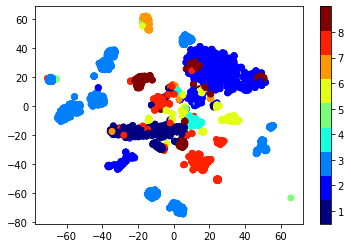

In [ ]:
xtsne=TSNE(perplexity=50)
results=xtsne.fit_transform(result_x)
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=result_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(9))
plt.clim(0.5, 9)
plt.show()

<h3>Train and Test split</h3>

In [ ]:
X_train, X_test_merge, y_train, y_test_merge = train_test_split(result_x, result_y,stratify=result_y,test_size=0.20)
X_train_merge, X_cv_merge, y_train_merge, y_cv_merge = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

<h3>Random Forest Classifier</h3>

log_loss for c =  10 is 0.07013683059617695
log_loss for c =  50 is 0.06446687514297832
log_loss for c =  100 is 0.06162433428839129
log_loss for c =  500 is 0.0603358169045905
log_loss for c =  1000 is 0.06010473583660184
log_loss for c =  2000 is 0.06018759164311288
log_loss for c =  3000 is 0.060408695551309136


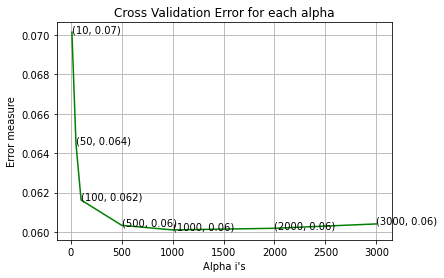

For values of best alpha =  1000 The train log loss is: 0.03264537113037737
For values of best alpha =  1000 The cross validation log loss is: 0.06010473583660184
For values of best alpha =  1000 The test log loss is: 0.07602606471168474


In [ ]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train_merge,y_train_merge)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train_merge, y_train_merge)
    predict_y = sig_clf.predict_proba(X_cv_merge)
    cv_log_error_array.append(log_loss(y_cv_merge, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train_merge,y_train_merge)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train_merge, y_train_merge)

predict_y = sig_clf.predict_proba(X_train_merge)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_merge, predict_y))
predict_y = sig_clf.predict_proba(X_cv_merge)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv_merge, predict_y))
predict_y = sig_clf.predict_proba(X_test_merge)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_merge, predict_y))

<h3>XgBoost Classifier</h3>

log_loss for c =  10 is 0.10077082628653249
log_loss for c =  50 is 0.044211624498988675
log_loss for c =  100 is 0.033603408702398765
log_loss for c =  500 is 0.03417142625754249
log_loss for c =  1000 is 0.03532135076787721
log_loss for c =  2000 is 0.03572364466866628
log_loss for c =  3000 is 0.0357240391479498


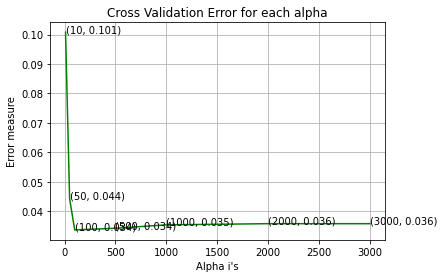

For values of best alpha =  100 The train log loss is: 0.02693262037226305
For values of best alpha =  100 The cross validation log loss is: 0.0357240391479498
For values of best alpha =  100 The test log loss is: 0.07030180940991207


In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i)
    x_cfl.fit(X_train_merge,y_train_merge)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train_merge, y_train_merge)
    predict_y = sig_clf.predict_proba(X_cv_merge)
    cv_log_error_array.append(log_loss(y_cv_merge, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train_merge,y_train_merge,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_merge, y_train_merge)

predict_y = sig_clf.predict_proba(X_train_merge)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_merge, predict_y))
predict_y = sig_clf.predict_proba(X_cv_merge)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv_merge, predict_y))
predict_y = sig_clf.predict_proba(X_test_merge)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_merge, predict_y))

<h3>XgBoost Classifier with best hyper parameters using Random search</h3>

In [ ]:
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(X_train_merge, y_train_merge)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 18.3min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_it

In [ ]:
print (random_cfl.best_params_)

{'subsample': 1, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.3}


For values of best alpha =  100 The train log loss is: 0.02543102994996448
For values of best alpha =  100 The cross validation log loss is: 0.029536174111115584
For values of best alpha =  100 The test log loss is: 0.060484258310481084
Number of misclassified points  83.0952380952381
-------------------------------------------------- Confusion matrix --------------------------------------------------


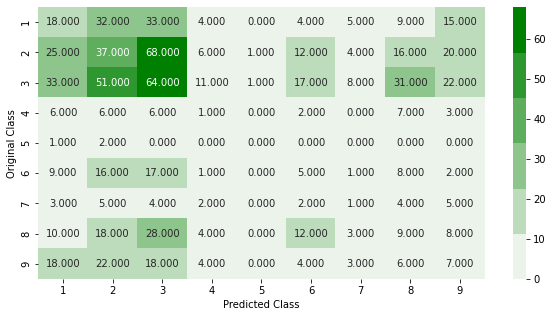

-------------------------------------------------- Precision matrix --------------------------------------------------


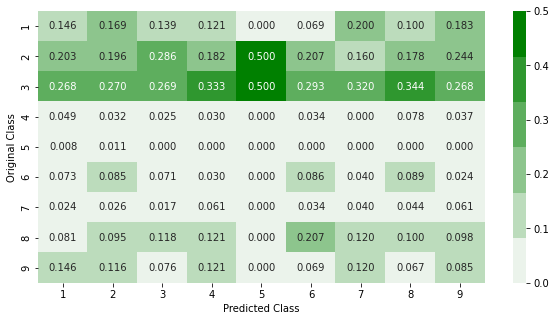

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


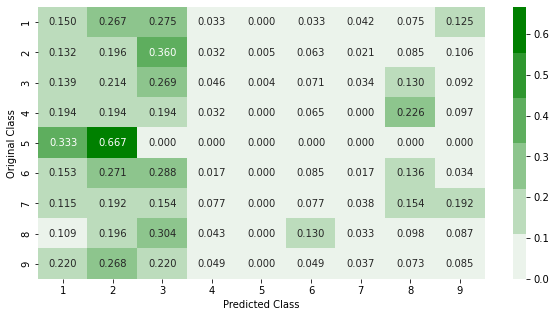

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

x_cfl=XGBClassifier(n_estimators=1000,max_depth=3,learning_rate=0.01,colsample_bytree=0.3,subsample=1,nthread=-1)
x_cfl.fit(X_train_merge,y_train_merge,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_merge, y_train_merge)
    
predict_y = sig_clf.predict_proba(X_train_merge)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_merge, predict_y))
predict_y = sig_clf.predict_proba(X_cv_merge)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv_merge, predict_y))
predict_y = sig_clf.predict_proba(X_test_merge)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_merge, predict_y))
plot_confusion_matrix(y_test_merge,sig_clf.predict(X_test_merge))

<h3>Calculating Bigram features .bytes files</h3>

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix

In [ ]:
tokens="00,01,02,03,04,05,06,07,08,09,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,2b,2c,2d,2e,2f,30,31,32,33,34,35,36,\
37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,66,67,68,69,6a,6b,6c,6d,6e,6f,70,\
71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,87,88,89,8a,8b,8c,8d,8e,8f,90,91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,\
ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,ba,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,db,dc,dd,de,df,e0,e1,e2,e3,e4,\
e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff,??"

In [ ]:
bigram_feature_names=[]
for v1 in tokens.split(','):
    for v2 in tokens.split(','):
        bigram_feature_names.append(v1+" "+v2)

In [ ]:
n_bigram_features=len(bigram_feature_names)

In [ ]:
print(n_bigram_features)

66049


In [ ]:
files = os.listdir('byteFiles')

In [ ]:
files_sorted=sorted(files,key = lambda s: s.casefold())

In [ ]:
file_names=[]
for i,file in enumerate(files_sorted):
    file_names.append(file)

In [ ]:
#files=os.listdir('byteFiles')
filenames=Y['Id'].tolist()
class_y=Y['Class'].tolist()
classbytes=[]
fnames=[]
for file in files_sorted:
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        classbytes.append(class_y[i])
        fnames.append(file)
bigrams_class=pd.DataFrame({'ID':fnames,'Class':classbytes})
print(bigrams_class.head())

                     ID  Class
0  01azqd4InC7m9JpocGv5      9
1  01IsoiSMh5gxyDYTl4CB      2
2  01jsnpXSAlgw6aPeDxrU      9
3  01kcPWA9K2BOxQeS5Rju      1
4  01SuzwMJEIXsK7A8dQbl      8


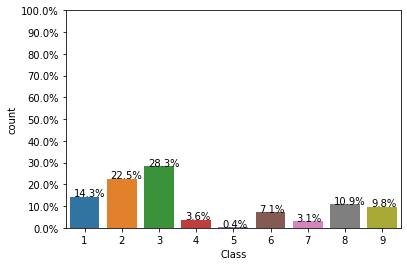

In [ ]:
total = len(bigrams_class)*1.
ax=sns.countplot(x="Class", data=bigrams_class)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

In [ ]:
from tqdm import tqdm
import scipy.sparse as sp

In [ ]:
byte_bigrams=csr_matrix((4200,n_bigram_features))
vectorizer=CountVectorizer(ngram_range=(2,2),vocabulary=bigram_feature_names)

In [ ]:
for i,file in tqdm(enumerate(files_sorted[0:2100])):
    with open('byteFiles/'+file) as byte_flie:
        X=vectorizer.fit_transform([byte_flie.read().replace('\n',' ')])
        byte_bigrams[i,:]+=csr_matrix(X)
    byte_flie.close()

2100it [1:10:21,  2.01s/it]


In [ ]:
sp.save_npz('/content/drive/My Drive/Colab Notebooks/MicrosoftMalware/bigrams1.npz',byte_bigrams)

In [ ]:
for i,file in tqdm(enumerate(files_sorted[2100:],2100)):
    with open('byteFiles/'+file) as byte_flie:
        X=vectorizer.fit_transform([byte_flie.read().replace('\n',' ')])
        byte_bigrams[i,:]+=csr_matrix(X)
    byte_flie.close()

2100it [2:17:13,  3.92s/it]


In [ ]:
sp.save_npz('/content/drive/My Drive/Colab Notebooks/MicrosoftMalware/bigrams.npz',byte_bigrams)

In [ ]:
byte_bigrams=sp.load_npz('/content/drive/My Drive/Colab Notebooks/MicrosoftMalware/bigrams.npz')

In [ ]:
clf=RandomForestClassifier(n_jobs=-1)
clf.fit(byte_bigrams,classbytes)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
feature_imp=clf.feature_importances_

In [ ]:
feature_imp_indx=np.argsort(feature_imp)[::-1]
top_feature_indx=feature_imp_indx[:2000]
top_feature_names=np.take(bigram_feature_names,top_feature_indx)

In [ ]:
top_byte_bigrams=byte_bigrams[:,top_feature_indx].todense()

In [ ]:
top_byte_bigrams.shape

(4200, 2000)

In [ ]:
# Pick top 2000 features
#top_byte_bigrams= np.zeros((4000, 0))
#for i in top_feature_indx:
 #   sliced = byte_bigrams[:, i].todense()
 #   top_byte_bigrams = np.hstack([top_byte_bigrams, sliced])

In [ ]:
bigrams_result=pd.DataFrame(top_byte_bigrams,columns=top_feature_names)

In [ ]:
bigrams_result.insert(0,column='ID',value=files_sorted)

In [ ]:
bigrams_result['ID']=bigrams_result['ID'].str.split('.').str[0]
bigrams_result.head(2)

ID  f5 7b  a9 1e  cb 1e  ...  44 8f  60 5d  19 ac  56 85
0  01azqd4InC7m9JpocGv5    5.0    6.0    1.0  ...    6.0    4.0    8.0    7.0
1  01IsoiSMh5gxyDYTl4CB    0.0    0.0    1.0  ...   29.0    0.0    0.0    1.0

[2 rows x 2001 columns]

In [ ]:
bigrams_result.to_csv("/content/drive/My Drive/Colab Notebooks/MicrosoftMalware/bigrams_byte_features.csv", index=False)

In [ ]:
bigrams_result.head()

ID  f5 7b  a9 1e  cb 1e  ...  44 8f  60 5d  19 ac  56 85
0  01azqd4InC7m9JpocGv5    5.0    6.0    1.0  ...    6.0    4.0    8.0    7.0
1  01IsoiSMh5gxyDYTl4CB    0.0    0.0    1.0  ...   29.0    0.0    0.0    1.0
2  01jsnpXSAlgw6aPeDxrU    8.0    6.0  297.0  ...    3.0    4.0    7.0  125.0
3  01kcPWA9K2BOxQeS5Rju    6.0    1.0    1.0  ...    1.0    5.0    4.0    4.0
4  01SuzwMJEIXsK7A8dQbl    0.0    1.0    2.0  ...    1.0    2.0    2.0    1.0

[5 rows x 2001 columns]

In [ ]:
bigrams_result=pd.read_csv("/content/drive/My Drive/Colab Notebooks/MicrosoftMalware/bigrams_byte_features.csv")

In [ ]:
bigrams_byte_features = bigrams_result.merge(data_size_byte,on='ID')
bigrams_byte_features.head(2)

ID  f5 7b  a9 1e  cb 1e  ...  19 ac  56 85      size  Class
0  01azqd4InC7m9JpocGv5    5.0    6.0    1.0  ...    8.0    7.0  5.012695      9
1  01IsoiSMh5gxyDYTl4CB    0.0    0.0    1.0  ...    0.0    1.0  6.556152      2

[2 rows x 2003 columns]

In [ ]:
# https://stackoverflow.com/a/29651514
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1
result_bigrams=normalize(bigrams_byte_features)

In [ ]:
result_bigrams.head(2)

ID     f5 7b     a9 1e  ...     56 85      size  Class
0  01azqd4InC7m9JpocGv5  0.016502  0.009174  ...  0.000877  0.364407      9
1  01IsoiSMh5gxyDYTl4CB  0.000000  0.000000  ...  0.000125  0.479873      2

[2 rows x 2003 columns]

In [ ]:
data_y=result_bigrams['Class']
result_bigrams.head()

ID     f5 7b     a9 1e  ...     56 85      size  Class
0  01azqd4InC7m9JpocGv5  0.016502  0.009174  ...  0.000877  0.364407      9
1  01IsoiSMh5gxyDYTl4CB  0.000000  0.000000  ...  0.000125  0.479873      2
2  01jsnpXSAlgw6aPeDxrU  0.026403  0.009174  ...  0.015660  0.333686      9
3  01kcPWA9K2BOxQeS5Rju  0.019802  0.001529  ...  0.000501  0.040254      1
4  01SuzwMJEIXsK7A8dQbl  0.000000  0.001529  ...  0.000125  0.022246      8

[5 rows x 2003 columns]

<h1>Train Test split</h1>

In [ ]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(result_bigrams.drop(['ID','Class'], axis=1), data_y,stratify=data_y,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

In [ ]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 2688
Number of data points in test data: 840
Number of data points in cross validation data: 672


<h3>Random Forest Classifier </h3>

log_loss for c =  10 is 0.11308420444940119
log_loss for c =  50 is 0.09657848149483239
log_loss for c =  100 is 0.09544000870285445
log_loss for c =  500 is 0.09234675105174402
log_loss for c =  1000 is 0.09202758849266306
log_loss for c =  2000 is 0.09174158753148179
log_loss for c =  3000 is 0.09209016190163737


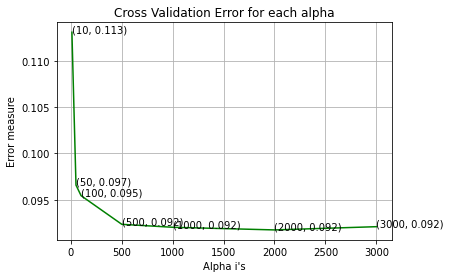

For values of best alpha =  2000 The train log loss is: 0.03266797745934493
For values of best alpha =  2000 The cross validation log loss is: 0.09174158753148179
For values of best alpha =  2000 The test log loss is: 0.09605870341122047
Number of misclassified points  1.4285714285714286
-------------------------------------------------- Confusion matrix --------------------------------------------------


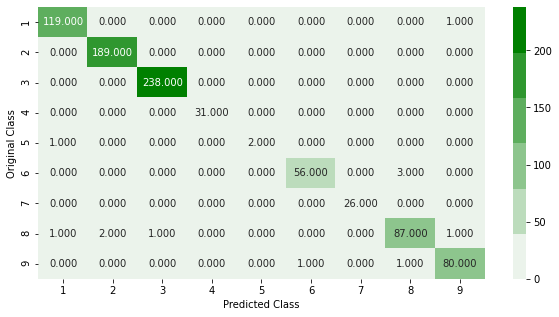

-------------------------------------------------- Precision matrix --------------------------------------------------


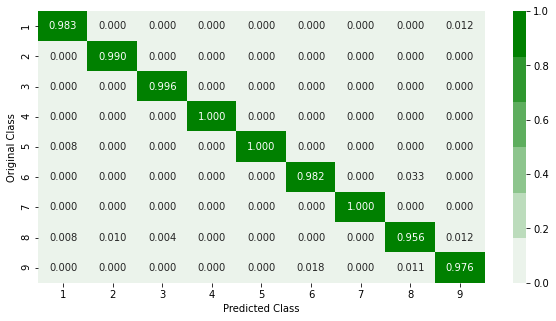

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


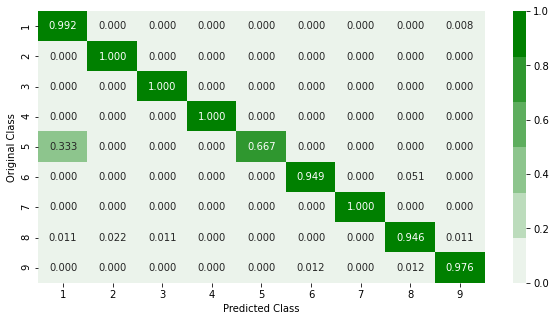

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

<h3>XgBoost Classification</h3>

<h3>XgBoost Classification with best hyper parameters using RandomSearch </h3>

In [ ]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl1.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 64.5min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 101.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 143.7min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 197.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 201.3min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_it

In [ ]:
print (random_cfl1.best_params_)

{'subsample': 0.3, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.5}


In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

x_cfl=XGBClassifier(n_estimators=100, learning_rate=0.2, colsample_bytree=0.5, max_depth=3,subsample=0.3)
x_cfl.fit(X_train,y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train,y_train)

predict_y = c_cfl.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))
predict_y = c_cfl.predict_proba(X_cv)
print ('cv loss',log_loss(y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test)
print ('test loss',log_loss(y_test, predict_y))

train loss 0.029729509614025117
cv loss 0.08749216436219881
test loss 0.0989672855131921


In [ ]:
#Delete all the byte files
!rm -r -f byteFiles/

In [ ]:
bigrams_result=pd.read_csv("/content/drive/My Drive/Colab Notebooks/MicrosoftMalware/bigrams_byte_features.csv")

In [ ]:
# https://stackoverflow.com/a/29651514
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1
result_bigrams=normalize(bigrams_result)

<h2>Machine Learning models on features of .asm files and unigram + bigram features of .bytes files</h2>

In [ ]:
result_unigrams.head()

ID         0         1  ...        ??      size  Class
0  01azqd4InC7m9JpocGv5  0.527809  0.008309  ...  0.000752  0.364407      9
1  01IsoiSMh5gxyDYTl4CB  0.034861  0.017739  ...  0.003540  0.479873      2
2  01jsnpXSAlgw6aPeDxrU  0.081995  0.020303  ...  0.000193  0.333686      9
3  01kcPWA9K2BOxQeS5Rju  0.018495  0.002581  ...  0.005746  0.040254      1
4  01SuzwMJEIXsK7A8dQbl  0.017331  0.001511  ...  0.003713  0.022246      8

[5 rows x 260 columns]

In [ ]:
result_bigrams.head()

ID     f5 7b     a9 1e  ...     60 5d     19 ac     56 85
0  01azqd4InC7m9JpocGv5  0.016502  0.009174  ...  0.000886  0.003296  0.000877
1  01IsoiSMh5gxyDYTl4CB  0.000000  0.000000  ...  0.000000  0.000000  0.000125
2  01jsnpXSAlgw6aPeDxrU  0.026403  0.009174  ...  0.000886  0.002884  0.015660
3  01kcPWA9K2BOxQeS5Rju  0.019802  0.001529  ...  0.001107  0.001648  0.000501
4  01SuzwMJEIXsK7A8dQbl  0.000000  0.001529  ...  0.000443  0.000824  0.000125

[5 rows x 2001 columns]

In [ ]:
result_asm.head()

ID   HEADER:    .text:  ...       eip  Class          size
0  01kcPWA9K2BOxQeS5Rju  0.215909  0.001092  ...  0.003173      1  4.278698e-04
1  1E93CpP60RHFNiT5Qfvn  0.193182  0.001230  ...  0.002188      1  3.215958e-04
2  3ekVow2ajZHbTnBcsDfX  0.193182  0.000627  ...  0.000985      1  1.656338e-04
3  3X2nY7iQaPBIWDrAZqJe  0.193182  0.000333  ...  0.000657      1  8.119654e-07
4  46OZzdsSKDCFV8h7XWxf  0.193182  0.000590  ...  0.001204      1  1.359719e-04

[5 rows x 54 columns]

In [ ]:
result_m = pd.merge(result_unigrams,result_bigrams,on='ID', how='left')
result_y = result_m['Class']
result_m.head()

ID         0         1  ...     60 5d     19 ac     56 85
0  01azqd4InC7m9JpocGv5  0.527809  0.008309  ...  0.000886  0.003296  0.000877
1  01IsoiSMh5gxyDYTl4CB  0.034861  0.017739  ...  0.000000  0.000000  0.000125
2  01jsnpXSAlgw6aPeDxrU  0.081995  0.020303  ...  0.000886  0.002884  0.015660
3  01kcPWA9K2BOxQeS5Rju  0.018495  0.002581  ...  0.001107  0.001648  0.000501
4  01SuzwMJEIXsK7A8dQbl  0.017331  0.001511  ...  0.000443  0.000824  0.000125

[5 rows x 2260 columns]

In [ ]:
result_x=pd.merge(result_m,result_asm.drop(['Class','rtn','.BSS:','.CODE'],axis=1),on='ID',how='left')
result_x.head()

ID         0         1  ...       esp       eip    size_y
0  01azqd4InC7m9JpocGv5  0.527809  0.008309  ...  0.000428  0.049896  0.403908
1  01IsoiSMh5gxyDYTl4CB  0.034861  0.017739  ...  0.000673  0.024839  0.100459
2  01jsnpXSAlgw6aPeDxrU  0.081995  0.020303  ...  0.000000  0.012802  0.060999
3  01kcPWA9K2BOxQeS5Rju  0.018495  0.002581  ...  0.001468  0.003173  0.000428
4  01SuzwMJEIXsK7A8dQbl  0.017331  0.001511  ...  0.000000  0.008316  0.007028

[5 rows x 2309 columns]

In [ ]:
result_x.to_csv("/content/drive/My Drive/Colab Notebooks/MicrosoftMalware/merge_uni_bi_grams_asm.csv", index=False)

In [ ]:
result_x=pd.read_csv("/content/drive/My Drive/Colab Notebooks/MicrosoftMalware/merge_uni_bi_grams_asm.csv")

In [ ]:
result_y = result_x['Class']
result_x=result_x.drop(['ID','Class'], axis=1)
result_x.head()

0         1         2  ...       esp       eip    size_y
0  0.527809  0.008309  0.002647  ...  0.000428  0.049896  0.403908
1  0.034861  0.017739  0.006813  ...  0.000673  0.024839  0.100459
2  0.081995  0.020303  0.002414  ...  0.000000  0.012802  0.060999
3  0.018495  0.002581  0.000682  ...  0.001468  0.003173  0.000428
4  0.017331  0.001511  0.000284  ...  0.000000  0.008316  0.007028

[5 rows x 2307 columns]

In [ ]:
X_train, X_test_merge, y_train, y_test_merge = train_test_split(result_x, result_y,stratify=result_y,test_size=0.20)
X_train_merge, X_cv_merge, y_train_merge, y_cv_merge = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

<h3>Random Forest Classifier </h3>

log_loss for c =  10 is 0.09098403273364844
log_loss for c =  50 is 0.07254243956557259
log_loss for c =  100 is 0.07198210947002881
log_loss for c =  500 is 0.06890555658673754
log_loss for c =  1000 is 0.0696304122304924
log_loss for c =  2000 is 0.06986596482479912
log_loss for c =  3000 is 0.06962454979325429


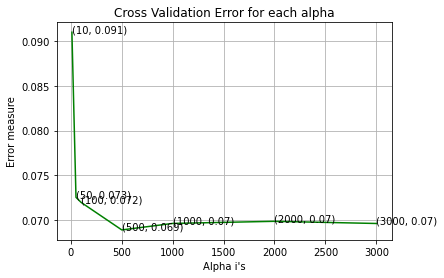

For values of best alpha =  500 The train log loss is: 0.032247537923128296
For values of best alpha =  500 The cross validation log loss is: 0.06890555658673754
For values of best alpha =  500 The test log loss is: 0.06700972995238295
Number of misclassified points  1.1904761904761905
-------------------------------------------------- Confusion matrix --------------------------------------------------


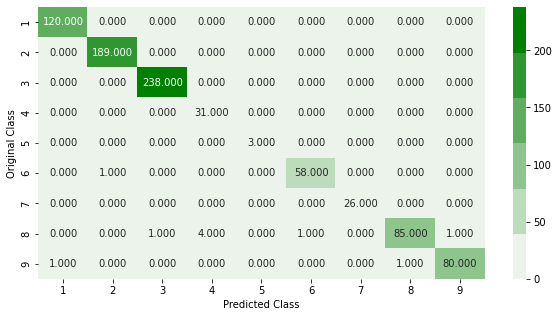

-------------------------------------------------- Precision matrix --------------------------------------------------


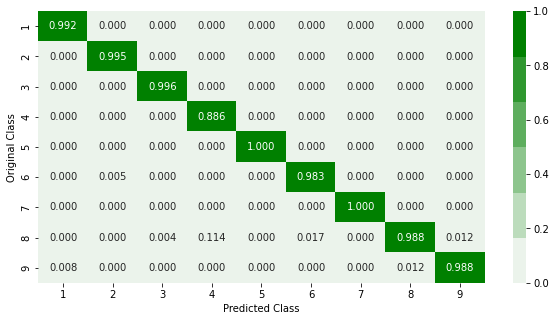

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


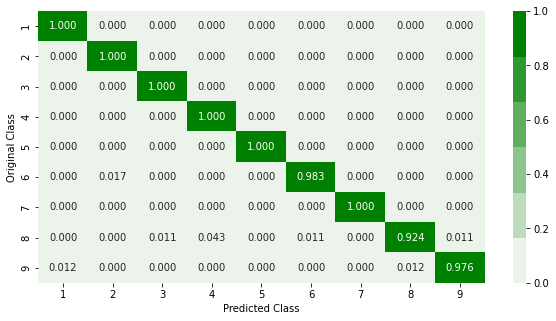

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train_merge,y_train_merge)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train_merge, y_train_merge)
    predict_y = sig_clf.predict_proba(X_cv_merge)
    cv_log_error_array.append(log_loss(y_cv_merge, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train_merge,y_train_merge)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train_merge, y_train_merge)

predict_y = sig_clf.predict_proba(X_train_merge)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_merge, predict_y))
predict_y = sig_clf.predict_proba(X_cv_merge)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv_merge, predict_y))
predict_y = sig_clf.predict_proba(X_test_merge)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_merge, predict_y))
plot_confusion_matrix(y_test_merge, sig_clf.predict(X_test_merge))

<h3>XgBoost Classification</h3>

In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train_merge,y_train_merge)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train_merge, y_train_merge)
    predict_y = sig_clf.predict_proba(X_cv_merge)
    cv_log_error_array.append(log_loss(y_cv_merge, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train_merge,y_train_merge,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_merge, y_train_merge)

predict_y = sig_clf.predict_proba(X_train_merge)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_merge, predict_y))
predict_y = sig_clf.predict_proba(X_cv_merge)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv_merge, predict_y))
predict_y = sig_clf.predict_proba(X_test_merge)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_merge, predict_y))
plot_confusion_matrix(y_test_merge, sig_clf.predict(X_test_merge))

log_loss for c =  10 is 0.1037636427594136
log_loss for c =  50 is 0.06775773409147182
log_loss for c =  100 is 0.06194705053494491
log_loss for c =  500 is 0.06307275648349131
log_loss for c =  1000 is 0.06307318905763101
log_loss for c =  2000 is 0.06307320559820105
log_loss for c =  3000 is 0.06307312291754551


<IPython.core.display.Javascript object>

For values of best alpha =  100 The train log loss is: 0.025919686404303394
For values of best alpha =  100 The cross validation log loss is: 0.06307312291754551
For values of best alpha =  100 The test log loss is: 0.06590734040219354


<h3>XgBoost Classification with best hyper parameters using RandomSearch </h3>

In [ ]:
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(X_train_merge, y_train_merge)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 36.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 49.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 77.9min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 85.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 102.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 114.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 127.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 136.3min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_it

In [ ]:
print (random_cfl.best_params_)

{'subsample': 1, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 1}


The train log loss is: 0.027262692428596347
The cross validation log loss is: 0.04894664989956301
The test log loss is: 0.05248699305554538
Number of misclassified points  0.4761904761904762
-------------------------------------------------- Confusion matrix --------------------------------------------------


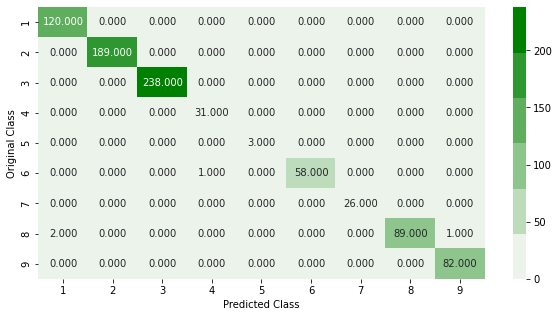

-------------------------------------------------- Precision matrix --------------------------------------------------


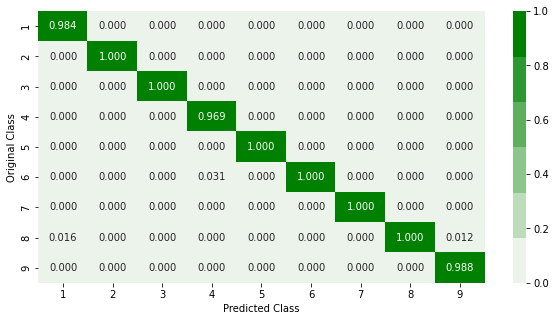

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


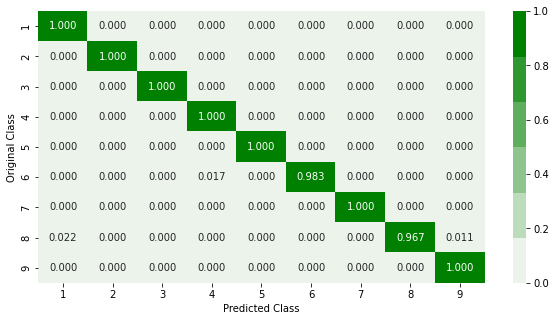

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
x_cfl=XGBClassifier(n_estimators=500,max_depth=3,learning_rate=0.2,colsample_bytree=1,subsample=1,nthread=-1)
x_cfl.fit(X_train_merge,y_train_merge,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_merge, y_train_merge)
    
predict_y = sig_clf.predict_proba(X_train_merge)
print ("The train log loss is:",log_loss(y_train_merge, predict_y))
predict_y = sig_clf.predict_proba(X_cv_merge)
print("The cross validation log loss is:",log_loss(y_cv_merge, predict_y))
predict_y = sig_clf.predict_proba(X_test_merge)
print("The test log loss is:",log_loss(y_test_merge, predict_y))
plot_confusion_matrix(y_test_merge,sig_clf.predict(X_test_merge))

<h2>Pixel Intensity Features from ASM Files</h2>

In [ ]:
from datetime import datetime
import imageio
import array
import cv2

In [ ]:
!mkdir asmbatch

In [ ]:
!mkdir asmimages

In [ ]:
asm_size=[]

In [ ]:
count=0
batch=0
time_taken=[]
start=datetime.now()
for file in asm_file_name[4100:4200]: #calculated batchwise
  # start=datetime.now()
  if(batch == 10):
    print('Batch 10 breaking')
    break
  
  !7z e train.7z -o/content/asmbatch *$file -r
  count+=1
  #Add your code here
  filename=file.split('.')[0]
  f=open("asmbatch/" +file, 'rb')
  leng = os.path.getsize("asmbatch/" +file) # length of file in bytes
  size=leng/(1024.0*1024.0)
  asm_size.append(round(size,6))
  width = int(leng**0.5)
  rem = leng%width
  a=array.array('B') # uint8 array
  a.fromfile(f,leng-rem)
  f.close()
  g=np.reshape(a,(int(len(a)/width), width))
  g=np.uint8(g)
  imageio.imwrite('asmimages/'+filename+'.png',g)
  
  if(count==10):
      count=0
      batch+=1
      !rm -r -f asmbatch/
      !mkdir asmbatch
      end=datetime.now()
      print('*'*50)
      print('end, start',end,start)
      difference=end-start
      start=datetime.now()
      time_taken.append('Time taken for the batch {} of ASM files is {}'.format(batch,difference))
      print('Time taken for the batch {} of ASM files is {}'.format(batch,difference))


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 18810691091 bytes (18 GiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 18810691091
Headers Size = 339764
Method = LZMA:24
Solid = +
Blocks = 94

  0%      9% . train/AvfiP4Bw9IqUEnQyOXbc.asm                                      19% . train/AvfiP4Bw9IqUEnQyOXbc.asm                                      27% 1 . train/AVG9IvBRfaEbZn1DhSNp.asm                                        35% 1 . train/AVG9IvBRfaEbZn1DhSNp.asm   

In [ ]:
pickle.dump(asm_size,open("/content/drive/MyDrive/Colab Notebooks/MicrosoftMalware/asmsize.p","wb"))

In [ ]:
asm_size=pickle.load(open("/content/drive/MyDrive/Colab Notebooks/MicrosoftMalware/asmsize.p","rb"))

In [ ]:
len(asm_size)

4200

In [ ]:
imagefeatures=np.zeros((4200,800),dtype=int)

In [ ]:
for i,asmfile in enumerate(asm_file_name[0:2500]):
    img=cv2.imread("asm_image/" + asmfile.split('.')[0] + '.png')
    imagefeatures[i,:] +=img.flatten()[:800]

In [ ]:
for i,asmfile in enumerate(asm_file_name[2500:4200],2500):
    img=cv2.imread("asm_image/" + asmfile.split('.')[0] + '.png')
    imagefeatures[i,:] +=img.flatten()[:800]

In [ ]:
pickle.dump(imagefeatures,open("/content/drive/MyDrive/Colab Notebooks/MicrosoftMalware/imagefeatures.p","wb"))

In [ ]:
imagefeatures=pickle.load(open("/content/drive/MyDrive/Colab Notebooks/MicrosoftMalware/imagefeatures.p","rb"))

In [ ]:
imagefeatures.shape

(4200, 800)

In [ ]:
imagefeaturenames=[]
for i in range(800):
  imagefeaturenames.append("pixel"+str(i))

In [ ]:
images_result=pd.DataFrame(imagefeatures,columns=imagefeaturenames)

In [ ]:
images_result.insert(0,column='ID',value=fnames)

In [ ]:
images_result.head()

ID  pixel0  pixel1  ...  pixel797  pixel798  pixel799
0  01azqd4InC7m9JpocGv5      72      72  ...       103       104       104
1  01IsoiSMh5gxyDYTl4CB      46      46  ...        32        32        32
2  01jsnpXSAlgw6aPeDxrU      72      72  ...       103       104       104
3  01kcPWA9K2BOxQeS5Rju      72      72  ...       103       104       104
4  01SuzwMJEIXsK7A8dQbl      72      72  ...       103       104       104

[5 rows x 801 columns]

In [ ]:
images_result.to_csv("/content/drive/MyDrive/Colab Notebooks/MicrosoftMalware/asm_image_features.csv", index=False)

In [ ]:
images_result.shape

(4200, 801)

<h2>Machine Learning models on features of .asm files+ASM Image features and unigram + bigram features of .bytes files</h2>

In [ ]:
result_m=pd.read_csv("/content/drive/My Drive/Colab Notebooks/MicrosoftMalware/merge_uni_bi_grams_asm.csv")

In [ ]:
result_m.head()

ID         0         1  ...       esp       eip    size_y
0  01azqd4InC7m9JpocGv5  0.527809  0.008309  ...  0.000428  0.049896  0.403908
1  01IsoiSMh5gxyDYTl4CB  0.034861  0.017739  ...  0.000673  0.024839  0.100459
2  01jsnpXSAlgw6aPeDxrU  0.081995  0.020303  ...  0.000000  0.012802  0.060999
3  01kcPWA9K2BOxQeS5Rju  0.018495  0.002581  ...  0.001468  0.003173  0.000428
4  01SuzwMJEIXsK7A8dQbl  0.017331  0.001511  ...  0.000000  0.008316  0.007028

[5 rows x 2309 columns]

In [ ]:
images_result=pd.read_csv("/content/drive/My Drive/Colab Notebooks/MicrosoftMalware/asm_image_features.csv")

In [ ]:
images_result.head()

ID  pixel0  pixel1  ...  pixel797  pixel798  pixel799
0  01azqd4InC7m9JpocGv5      72      72  ...       103       104       104
1  01IsoiSMh5gxyDYTl4CB      46      46  ...        32        32        32
2  01jsnpXSAlgw6aPeDxrU      72      72  ...       103       104       104
3  01kcPWA9K2BOxQeS5Rju      72      72  ...       103       104       104
4  01SuzwMJEIXsK7A8dQbl      72      72  ...       103       104       104

[5 rows x 801 columns]

In [ ]:
# https://stackoverflow.com/a/29651514
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1
images_result=normalize(images_result)

In [ ]:
images_result.head()

ID    pixel0    pixel1  ...  pixel797  pixel798  pixel799
0  01azqd4InC7m9JpocGv5  0.481928  0.481928  ...  0.898734       0.9       0.9
1  01IsoiSMh5gxyDYTl4CB  0.168675  0.168675  ...  0.000000       0.0       0.0
2  01jsnpXSAlgw6aPeDxrU  0.481928  0.481928  ...  0.898734       0.9       0.9
3  01kcPWA9K2BOxQeS5Rju  0.481928  0.481928  ...  0.898734       0.9       0.9
4  01SuzwMJEIXsK7A8dQbl  0.481928  0.481928  ...  0.898734       0.9       0.9

[5 rows x 801 columns]

In [ ]:
result_x = pd.merge(result_m,images_result,on='ID', how='left')
result_y = result_m['Class']
result_x.head()

ID         0         1  ...  pixel797  pixel798  pixel799
0  01azqd4InC7m9JpocGv5  0.527809  0.008309  ...  0.898734       0.9       0.9
1  01IsoiSMh5gxyDYTl4CB  0.034861  0.017739  ...  0.000000       0.0       0.0
2  01jsnpXSAlgw6aPeDxrU  0.081995  0.020303  ...  0.898734       0.9       0.9
3  01kcPWA9K2BOxQeS5Rju  0.018495  0.002581  ...  0.898734       0.9       0.9
4  01SuzwMJEIXsK7A8dQbl  0.017331  0.001511  ...  0.898734       0.9       0.9

[5 rows x 3109 columns]

In [ ]:
result_x=result_x.drop(['ID','Class'], axis=1)
result_x.head()

0         1         2  ...  pixel797  pixel798  pixel799
0  0.527809  0.008309  0.002647  ...  0.898734       0.9       0.9
1  0.034861  0.017739  0.006813  ...  0.000000       0.0       0.0
2  0.081995  0.020303  0.002414  ...  0.898734       0.9       0.9
3  0.018495  0.002581  0.000682  ...  0.898734       0.9       0.9
4  0.017331  0.001511  0.000284  ...  0.898734       0.9       0.9

[5 rows x 3107 columns]

In [ ]:
X_train, X_test_merge, y_train, y_test_merge = train_test_split(result_x, result_y,stratify=result_y,test_size=0.20)
X_train_merge, X_cv_merge, y_train_merge, y_cv_merge = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

<h3>Random Forest Classifier </h3>

<h3>XgBoost Classification</h3>

log_loss for c =  10 is 0.09930753325833638
log_loss for c =  50 is 0.05930459402198312
log_loss for c =  100 is 0.05321515485945915
log_loss for c =  500 is 0.054042115473098326
log_loss for c =  1000 is 0.05404305701792374
log_loss for c =  2000 is 0.054043199597530865
log_loss for c =  3000 is 0.05404323009792765


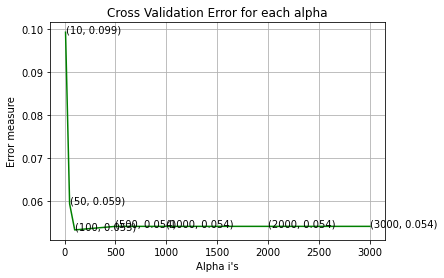

For values of best alpha =  100 The train log loss is: 0.02600729213638043
For values of best alpha =  100 The cross validation log loss is: 0.05404323009792765
For values of best alpha =  100 The test log loss is: 0.036795683492005606
Number of misclassified points  0.35714285714285715
-------------------------------------------------- Confusion matrix --------------------------------------------------


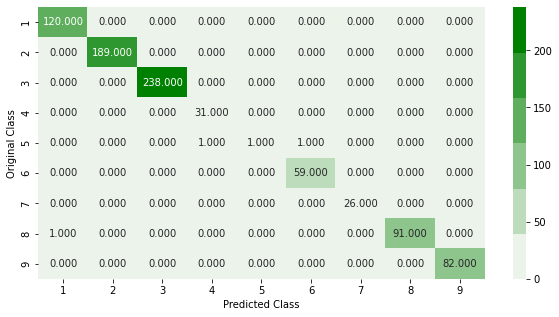

-------------------------------------------------- Precision matrix --------------------------------------------------


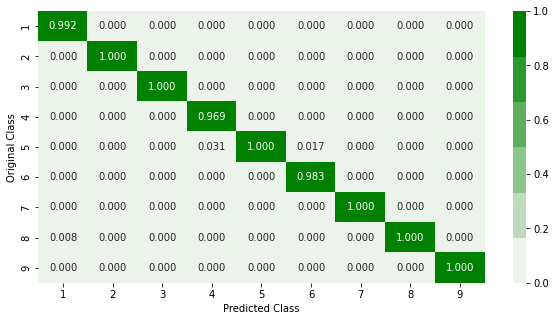

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


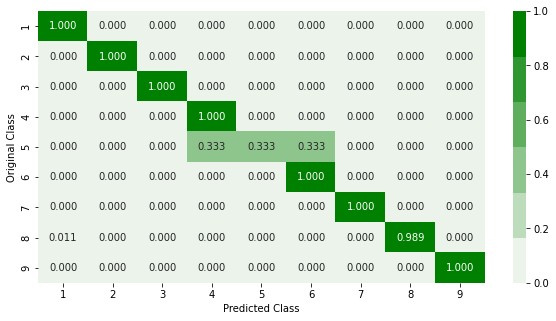

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i)
    x_cfl.fit(X_train_merge,y_train_merge)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train_merge, y_train_merge)
    predict_y = sig_clf.predict_proba(X_cv_merge)
    cv_log_error_array.append(log_loss(y_cv_merge, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train_merge,y_train_merge,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_merge, y_train_merge)

predict_y = sig_clf.predict_proba(X_train_merge)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_merge, predict_y))
predict_y = sig_clf.predict_proba(X_cv_merge)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv_merge, predict_y))
predict_y = sig_clf.predict_proba(X_test_merge)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_merge, predict_y))
plot_confusion_matrix(y_test_merge, sig_clf.predict(X_test_merge))

<h3>XgBoost Classification with best hyper parameters using RandomSearch </h3>

In [ ]:
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(X_train_merge, y_train_merge)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 54.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 108.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 190.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 208.6min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_it

In [ ]:
print (random_cfl.best_params_)

{'subsample': 0.5, 'n_estimators': 2000, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.3}


In [ ]:
x_cfl=XGBClassifier(n_estimators=2000,max_depth=3,learning_rate=0.2,colsample_bytree=0.3,subsample=0.5,nthread=-1)
x_cfl.fit(X_train_merge,y_train_merge,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_merge, y_train_merge)

For values of best alpha =  100 The train log loss is: 0.026484882448778568
For values of best alpha =  100 The cross validation log loss is: 0.058212745906161455
For values of best alpha =  100 The test log loss is: 0.03731324316000047
Number of misclassified points  0.4761904761904762
-------------------------------------------------- Confusion matrix --------------------------------------------------


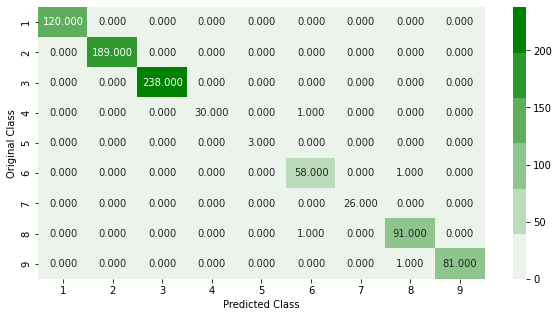

-------------------------------------------------- Precision matrix --------------------------------------------------


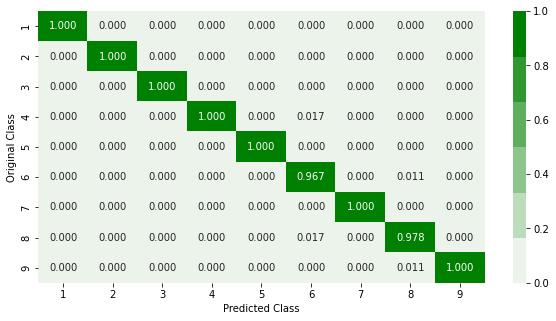

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


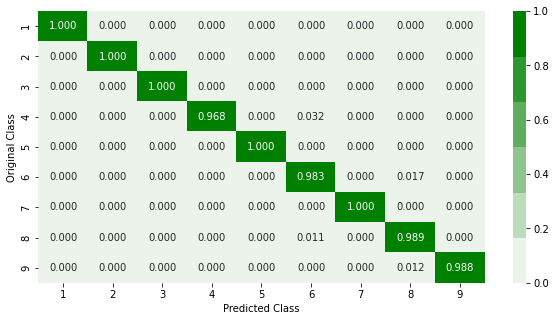

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
predict_y = sig_clf.predict_proba(X_train_merge)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_merge, predict_y))
predict_y = sig_clf.predict_proba(X_cv_merge)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv_merge, predict_y))
predict_y = sig_clf.predict_proba(X_test_merge)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_merge, predict_y))
plot_confusion_matrix(y_test_merge,sig_clf.predict(X_test_merge))

<h3>Models Comparison</h3>

In [24]:
from prettytable import PrettyTable
t = PrettyTable(['Model','features','log loss'])
t.add_row(['Random Forest Classifier','unigram byte features + asm features',0.076])
t.add_row(['XgBoost Classification with best hyper parameters','uni gram byte features + asm features',0.0604])
t.add_row(['---------------------------------------------------','-----------------------------------------------------------','--------------'])
t.add_row(['Random Forest Classifier','unigram + bigram byte features and asm features',0.067])
t.add_row(['XgBoost Classification with best hyper parameters','unigram + bigram byte features and asm features',0.0525])
t.add_row(['---------------------------------------------------','-----------------------------------------------------------','--------------'])
t.add_row(['XgBoost Classification','unigram + bigram byte features and asm features + asm image features',0.0368])
t.add_row(['XgBoost Classification with best hyper parameters','unigram + bigram byte features and asm features + asm image features',0.0373])
print(t)

+-----------------------------------------------------+----------------------------------------------------------------------+----------------+
|                        Model                        |                               features                               |    log loss    |
+-----------------------------------------------------+----------------------------------------------------------------------+----------------+
|               Random Forest Classifier              |                 unigram byte features + asm features                 |     0.076      |
|  XgBoost Classification with best hyper parameters  |                uni gram byte features + asm features                 |     0.0604     |
| --------------------------------------------------- |     -----------------------------------------------------------      | -------------- |
|               Random Forest Classifier              |           unigram + bigram byte features and asm features            |     0.067

<h2>Conclusion</h2>

<h3>Step by Step Procedure</h3>

1. First step is understanding the problem statement and accessing the data.
2. Next We will perform Exploratory Data Analysis on class distribution
3. We will perform Exploratory Data Analysis on features extracted from bytefiles.
4. We will extract features from ASM Files and perform EDA on the features extracted.
5. we will merge the byte and asm features and perform train test split on the features.
5. We will do modeling on byte and asm features and do HyperParameter tuning.
6. testing performance of model using metrics log loss and confusion matrix.
7. We will extract bigram byte features and apply modeling on unigram+bigram byte features and asm features to improve the logloss.
8. we will extract ASM Image features and apply modeling on unigram+bigram byte features and asm features+ASM Image features to improve the logloss.